In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
#from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/monthly-beer-production-in-austr.csv')
df.columns = ['Month', 'Production']
df.head()

,Month,Production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
df['Month'] = pd.to_datetime(df.Month)
df.set_index("Month", inplace=True)
df.head(n=2)

,Production
Month,
1956-01-01,93.2
1956-02-01,96.0


[Text(0, 0.5, 'Total production'), Text(0.5, 0, 'Dates')]

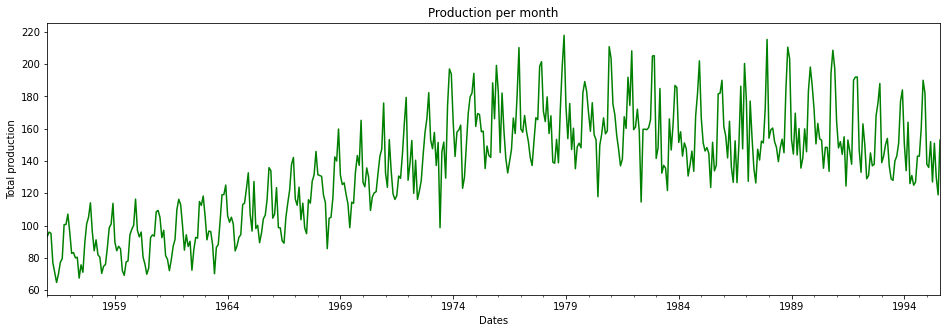

In [5]:
df.index.freq = 'MS'
ax = df['Production'].plot(figsize = (16,5), title='Production per month', c='green')
ax.set(xlabel='Dates', ylabel='Total production')

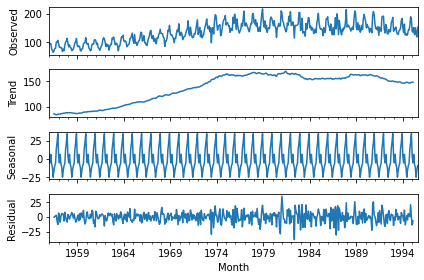

In [6]:
sd = seasonal_decompose(df.Production, model='add')
sd.plot();

In [7]:
#auto_arima(df['Monthly beer production'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

In [8]:
#Split data to train and test set
#by computing the auto_arima function we get  SARIMAX(2, 1, 1)x(4, 0, 3, 12)
train_df = df[:len(df)-12]
test_df = df[len(df)-12:]

sarima_model = SARIMAX(train_df['Production'], order=(2,1,1), seasonal_order=(4,0,3,12))
sarima_result = sarima_model.fit()
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Production   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(4, 0, 3, 12)   Log Likelihood               -1707.823
Date:                            Sat, 17 Apr 2021   AIC                           3437.646
Time:                                    00:01:44   BIC                           3483.161
Sample:                                01-01-1956   HQIC                          3455.564
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1204      0.042     -2.887      0.004      -0.202      -0.039
ar.L2         -0.1628      0.047     -3.484      0.000      -0.254      -0.071
ma.L1         -0.8474      0.028    -30.501      0.000      -0.902      -0.793
ar.S.L12       1.7703      0.088     20.007      0.000       1.597       1.944
ar.S.L24      -1.6399      0.153    -10.717      0.000      -1.940      -1.340
ar.S.L36       0.8140      0.107      7.610      0.000       0.604       1.024
ar.S.L48       0.0543      0.036      1.490      0.136      -0.017       0.126
ma.S.L12      -1.5731      0.108    -14.528      0.000      -1.785      -1.361
ma.S.L24       1.4182      0.171      8.302      0.000       1.083       1.753
ma.S.L36      -0.6758      0.098     -6.888      0.000      -0.868      -0.484
sigma2        86.2597      5.217     16.536      0.000      76.035      96.484
===================================================================================
Ljung-Box (Q):                       94.73   Jarque-Bera (JB):                41.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.06   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
sarima_pred = sarima_result.predict(start=len(train_df), end=len(df)-1, type='levels').rename('SARIMA predictions')
sarima_pred

1994-09-01    134.130001
1994-10-01    157.784518
1994-11-01    181.682829
1994-12-01    183.648517
1995-01-01    144.912765
1995-02-01    136.939697
1995-03-01    151.342967
1995-04-01    133.245995
1995-05-01    137.869569
1995-06-01    120.604404
1995-07-01    128.483950
1995-08-01    138.859363
Freq: MS, Name: SARIMA predictions, dtype: float64

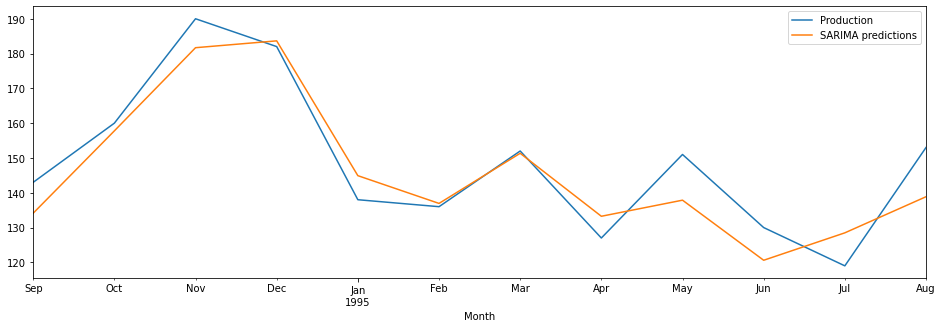

In [10]:
test_df['Production'].plot(figsize=(16,5), legend=True)
sarima_pred.plot(legend=True)

In [11]:
sarima_rmse = rmse(test_df['Production'], sarima_pred)
sarima_mse = sarima_rmse**2
mean_value = df['Production'].mean()

print(f"RMSE ERROR: {sarima_rmse}\nMSE: {sarima_mse}\nMEAN: {mean_value}")

RMSE ERROR: 8.135211833653191
MSE: 66.18167157841091
MEAN: 136.39537815126045


In [12]:
test_df['SARIMA_Predictions'] = sarima_pred

## LSTM Forecast

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train_df)
train_df_scaled = scaler.transform(train_df)
test_df_scaled = scaler.transform(test_df)

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [15]:
#Creating time serie generator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(train_df_scaled, train_df_scaled, length=n_input, batch_size=1)

In [16]:
#Model

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [17]:
lstm_model.fit_generator(generator=generator, epochs=20)


Epoch 1/20
452/452 [==============================] - 10s 22ms/step - loss: 0.0239
Epoch 2/20
452/452 [==============================] - 9s 20ms/step - loss: 0.0118
Epoch 3/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0097
Epoch 4/20
452/452 [==============================] - 9s 20ms/step - loss: 0.0074: 0s - 
Epoch 5/20
452/452 [==============================] - 9s 20ms/step - loss: 0.0085
Epoch 6/20
452/452 [==============================] - 10s 22ms/step - loss: 0.0069
Epoch 7/20
452/452 [==============================] - 9s 20ms/step - loss: 0.0079
Epoch 8/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0072 5s - l - ETA: 3s - los - ETA
Epoch 9/20
452/452 [==============================] - 10s 22ms/step - loss: 0.0074
Epoch 10/20
452/452 [==============================] - 9s 20ms/step - loss: 0.0065
Epoch 11/20
452/452 [==============================] - 10s 22ms/step - loss: 0.0073
Epoch 12/20
452/452 [==============================] 

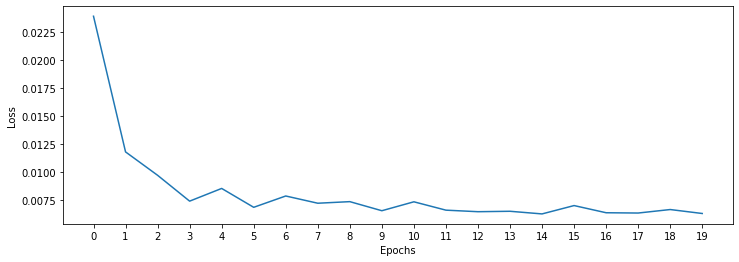

In [18]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [19]:
lstm_predictions_scaled = list()
batch = train_df_scaled[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for _ in range(len(test_df)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[147.99744158],
       [159.33005683],
       [176.53496211],
       [177.25520282],
       [154.46202557],
       [149.23130225],
       [158.86793475],
       [137.88231291],
       [137.88987299],
       [134.59949883],
       [137.75111963],
       [146.98485671]])

In [20]:
test_df['LSTM_Predictions'] = lstm_predictions
test_df

,Production,SARIMA_Predictions,LSTM_Predictions
Month,,,
1994-09-01,143.0,134.130001,147.997442
1994-10-01,160.0,157.784518,159.330057
1994-11-01,190.0,181.682829,176.534962
1994-12-01,182.0,183.648517,177.255203
1995-01-01,138.0,144.912765,154.462026
1995-02-01,136.0,136.939697,149.231302
1995-03-01,152.0,151.342967,158.867935
1995-04-01,127.0,133.245995,137.882313
1995-05-01,151.0,137.869569,137.889873


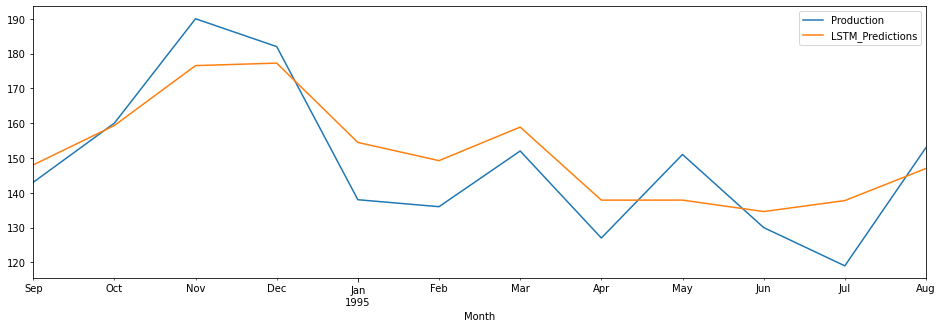

In [21]:
test_df['Production'].plot(figsize=(16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [22]:
lstm_rmse = rmse(test_df['Production'], test_df['LSTM_Predictions'])
lstm_mse = lstm_rmse**2
mean_value = df['Production'].mean()

print(f"RMSE ERROR: {lstm_rmse}\nMSE: {lstm_mse}\nMEAN: {mean_value}")

RMSE ERROR: 10.884697802840336
MSE: 118.47664625915723
MEAN: 136.39537815126045


## Prophet Forecast

In [23]:
from fbprophet import Prophet
import seaborn as sns

In [24]:
df_pr = df.copy()
df_pr = df.reset_index()

df_pr.columns = ['ds', 'y']

train_df_pr = df_pr.iloc[:len(df)-12] 
test_df_pr = df_pr.iloc[len(df)-12:]

In [25]:
pr_model = Prophet()
pr_model.fit(train_df_pr)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
future = pr_model.make_future_dataframe(periods=12, freq='MS')
pr_pred = pr_model.predict(future)

pr_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
471,1995-04-01,151.216973,130.918520,155.696156,151.157860,151.268961,-7.968873,-7.968873,-7.968873,-7.968873,-7.968873,-7.968873,0.0,0.0,0.0,143.248100
472,1995-05-01,151.154464,127.181509,152.194789,151.074581,151.230900,-11.385828,-11.385828,-11.385828,-11.385828,-11.385828,-11.385828,0.0,0.0,0.0,139.768636
473,1995-06-01,151.089871,115.731160,138.845993,150.990870,151.192833,-23.885026,-23.885026,-23.885026,-23.885026,-23.885026,-23.885026,0.0,0.0,0.0,127.204845
474,1995-07-01,151.027362,122.738465,147.590569,150.908251,151.152658,-15.754828,-15.754828,-15.754828,-15.754828,-15.754828,-15.754828,0.0,0.0,0.0,135.272534
475,1995-08-01,150.962769,129.790126,155.047431,150.818042,151.112489,-9.200811,-9.200811,-9.200811,-9.200811,-9.200811,-9.200811,0.0,0.0,0.0,141.761957


In [27]:
prophet_pred = pd.DataFrame({"Date" : pr_pred[-12:]['ds'], "Pred" : pr_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Date,
1994-09-01,145.125489
1994-10-01,166.187819
1994-11-01,173.792355
1994-12-01,186.054043
1995-01-01,155.337951
1995-02-01,146.913732
1995-03-01,159.042378
1995-04-01,143.248100
1995-05-01,139.768636


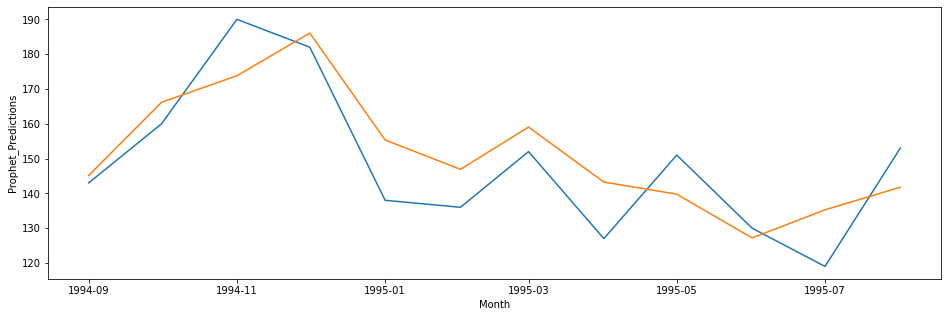

In [28]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values

plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Production"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [29]:
prophet_rmse = rmse(test_df['Production'], test_df['Prophet_Predictions'])
prophet_mse = prophet_rmse**2
mean_value = df['Production'].mean()

print(f"RMSE ERROR: {prophet_rmse}\nMSE: {prophet_mse}\nMEAN: {mean_value}")

RMSE ERROR: 11.475645028374124
MSE: 131.69042881724775
MEAN: 136.39537815126045


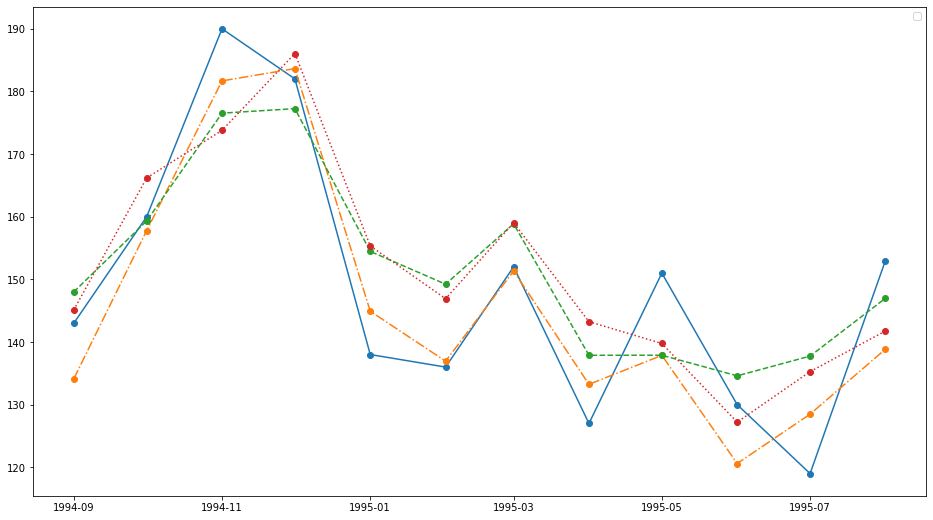

In [30]:
rmse_errors = [sarima_rmse, lstm_rmse, prophet_rmse]
mse_errors = [sarima_mse, lstm_mse, prophet_mse]

errors = pd.DataFrame({"Models" : ["SARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

plt.figure(figsize=(16,9))
plt.plot_date(test_df.index, test_df["Production"], linestyle="-")
plt.plot_date(test_df.index, test_df["SARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_df.index, test_df["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_df.index, test_df["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [31]:
print(f"Mean: {test_df['Production'].mean()}")
errors

Mean: 148.41666666666666


,Models,RMSE Errors,MSE Errors
0,SARIMA,8.135212,66.181672
1,LSTM,10.884698,118.476646
2,Prophet,11.475645,131.690429


In [32]:
test_df

,Production,SARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Month,,,,
1994-09-01,143.0,134.130001,147.997442,145.125489
1994-10-01,160.0,157.784518,159.330057,166.187819
1994-11-01,190.0,181.682829,176.534962,173.792355
1994-12-01,182.0,183.648517,177.255203,186.054043
1995-01-01,138.0,144.912765,154.462026,155.337951
1995-02-01,136.0,136.939697,149.231302,146.913732
1995-03-01,152.0,151.342967,158.867935,159.042378
1995-04-01,127.0,133.245995,137.882313,143.248100
1995-05-01,151.0,137.869569,137.889873,139.768636
